In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

2023-10-22 15:12:26.756181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 15:12:31.266937: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-10-22 15:12:31.268059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

# Loading Data and Intializing Variables

In [2]:
# Path to the images
#IMAGES_PATH = r"C:\Users\datai\Desktop\sample_data\images" 

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Use original size flag
USE_ORIGINAL_SIZE = True  # Set this to True if you want to use the original image sizes

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 420

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 60
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
def load_captions_data(filename):
    # Get the current working directory
    current_directory = os.getcwd()
    #IMAGES_PATH = r"C:\Users\eisha\Desktop\furniture\images"   # Specify the path to your images
    IMAGES_PATH = os.path.join(current_directory, "images")
    print(IMAGES_PATH)

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip("\n")
            # Split the line using a comma
            parts = line.split(",")

            if len(parts) < 2:
                continue

            img_name = parts[0]
            caption = ",".join(parts[1:])

            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # Handle long captions here, if needed

            if img_name.endswith("jpg"):
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                caption_mapping[img_name] = caption

        return caption_mapping, text_data


In [5]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
current_directory = os.getcwd()
data_captions_path = os.path.join(current_directory, "captions.txt")
#data_captions_path = r"C:\Users\eisha\Desktop\furniture\captions.txt"
captions_mapping, text_data = load_captions_data(data_captions_path)
#captions_mapping, text_data = load_captions_data('captions.txt')

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

/home/jupyter/tutorials/ai-platform/image_captioning/images
Number of training samples:  951
Number of validation samples:  238


In [6]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

2023-10-21 20:12:54.898770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-21 20:12:55.135105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-21 20:12:55.137147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-21 20:12:55.141753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

# loading and displaying images from dataest

In [9]:
import glob
import os

# Specify the directory path where your images are located
image_dir = '/home/jupyter/tutorials/ai-platform/image_captioning/images/'

# Use the glob library to list all the image files in the directory
image_files = glob.glob(os.path.join(image_dir, '*.jpg'))

# Diagnostic prints
print(f"Absolute path for search: {os.path.abspath(image_dir)}")
print("Does the directory exist?", os.path.exists(os.path.dirname(image_dir)))
print("Do I have read permissions?", os.access(os.path.dirname(image_dir), os.R_OK))
try:
    #print("Files in directory:", os.listdir(os.path.dirname(image_dir)))
    print("files found")
except Exception as e:
    print(f"Could not list files because: {e}")          

# Output
if not image_files:
    print("No image files found. Please check the directory path and file extension.")
else:
    print("Sample image paths:", image_files[:5])


Absolute path for search: /home/jupyter/tutorials/ai-platform/image_captioning/images
Does the directory exist? True
Do I have read permissions? True
files found
Sample image paths: ['/home/jupyter/tutorials/ai-platform/image_captioning/images/0d7a788d-1b9d-4865-b06e-f8db4e99f372_image_2.jpg', '/home/jupyter/tutorials/ai-platform/image_captioning/images/0e8ff5e1-1a47-487a-877f-d9a9ba9f0236_image_4.jpg', '/home/jupyter/tutorials/ai-platform/image_captioning/images/1b46820d-8707-4aeb-84c6-5027051900ba_image_1.jpg', '/home/jupyter/tutorials/ai-platform/image_captioning/images/1e36741d-3c87-40d5-a22d-1c3514191a97_image_9.jpg', '/home/jupyter/tutorials/ai-platform/image_captioning/images/2a8d4c56-fa77-4b67-a5a2-87e9a121c19a_image_5.jpg']


/home/jupyter/tutorials/ai-platform/image_captioning/images/0d7a788d-1b9d-4865-b06e-f8db4e99f372_image_2.jpg


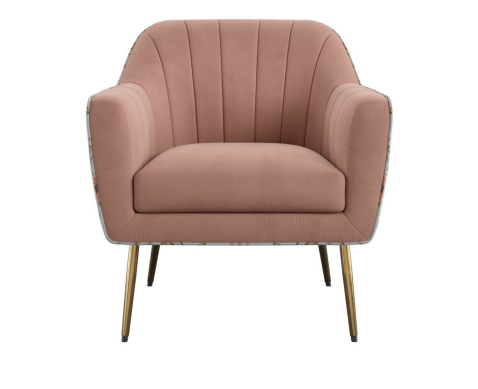

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Sample path
sample_path = image_files[0]
print(sample_path)

# Read the image file
img = tf.io.read_file(sample_path)

# Decode the image
img = tf.image.decode_jpeg(img, channels=3)

# Show the image using matplotlib
plt.imshow(img)
plt.axis('off')
plt.show()


In [11]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    #print(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    #if not USE_ORIGINAL_SIZE:
    #    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, caption):
    return decode_and_resize(img_path), vectorization(caption)

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset


# Create train and valid datasets
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

# Debug print to check datasets
print("train_dataset:", train_dataset)
print("valid_dataset:", valid_dataset)

train_dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>
valid_dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>


In [12]:
import tensorflow as tf

# Load an image from file
image_path = '/home/jupyter/tutorials/ai-platform/image_captioning/images/0d7a788d-1b9d-4865-b06e-f8db4e99f372_image_2.jpg'  # Replace with the actual path
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = tf.expand_dims(image, axis=0)  # Add a batch dimension
image = tf.cast(image, tf.float32)  # Cast to float32

# Get image dimensions
height, width, channels = image.shape[1:4]

# Use the dimensions as needed
print(f"Image dimensions: Height = {height}, Width = {width}, Channels = {channels}")


Image dimensions: Height = 2178, Width = 2700, Channels = 3


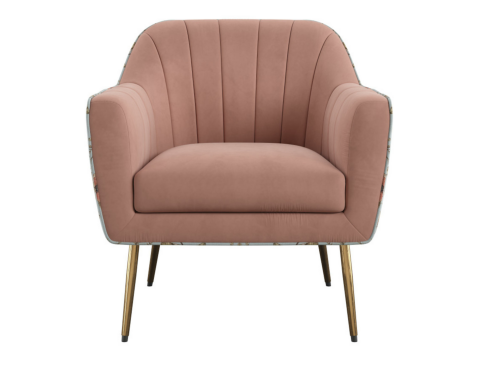

Image dimensions: Height = 2178, Width = 2700, Channels = 3


In [13]:
import matplotlib.pyplot as plt

# Convert the TensorFlow tensor to a NumPy array
image_np = image.numpy().squeeze()  # Remove the batch dimension

# Normalize the image data to [0, 1] if needed
if image_np.max() > 1.0:
    image_np = image_np / 255.0

# Plot the image
plt.imshow(image_np.astype('float32'))
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

print(f"Image dimensions: Height = {height}, Width = {width}, Channels = {channels}")


In [14]:

# If you want to print some elements from the datasets
train_iterator = iter(train_dataset)

# Print a few elements from the train_dataset
num_elements_to_print = 1
for _ in range(num_elements_to_print):
    try:
        images, captions = next(train_iterator)
        #print("Images:", images)
        
        #print("Captions:", captions.numpy())
    except StopIteration:
        break

Images: tf.Tensor(
[[[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  ...

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]]


 [[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
  

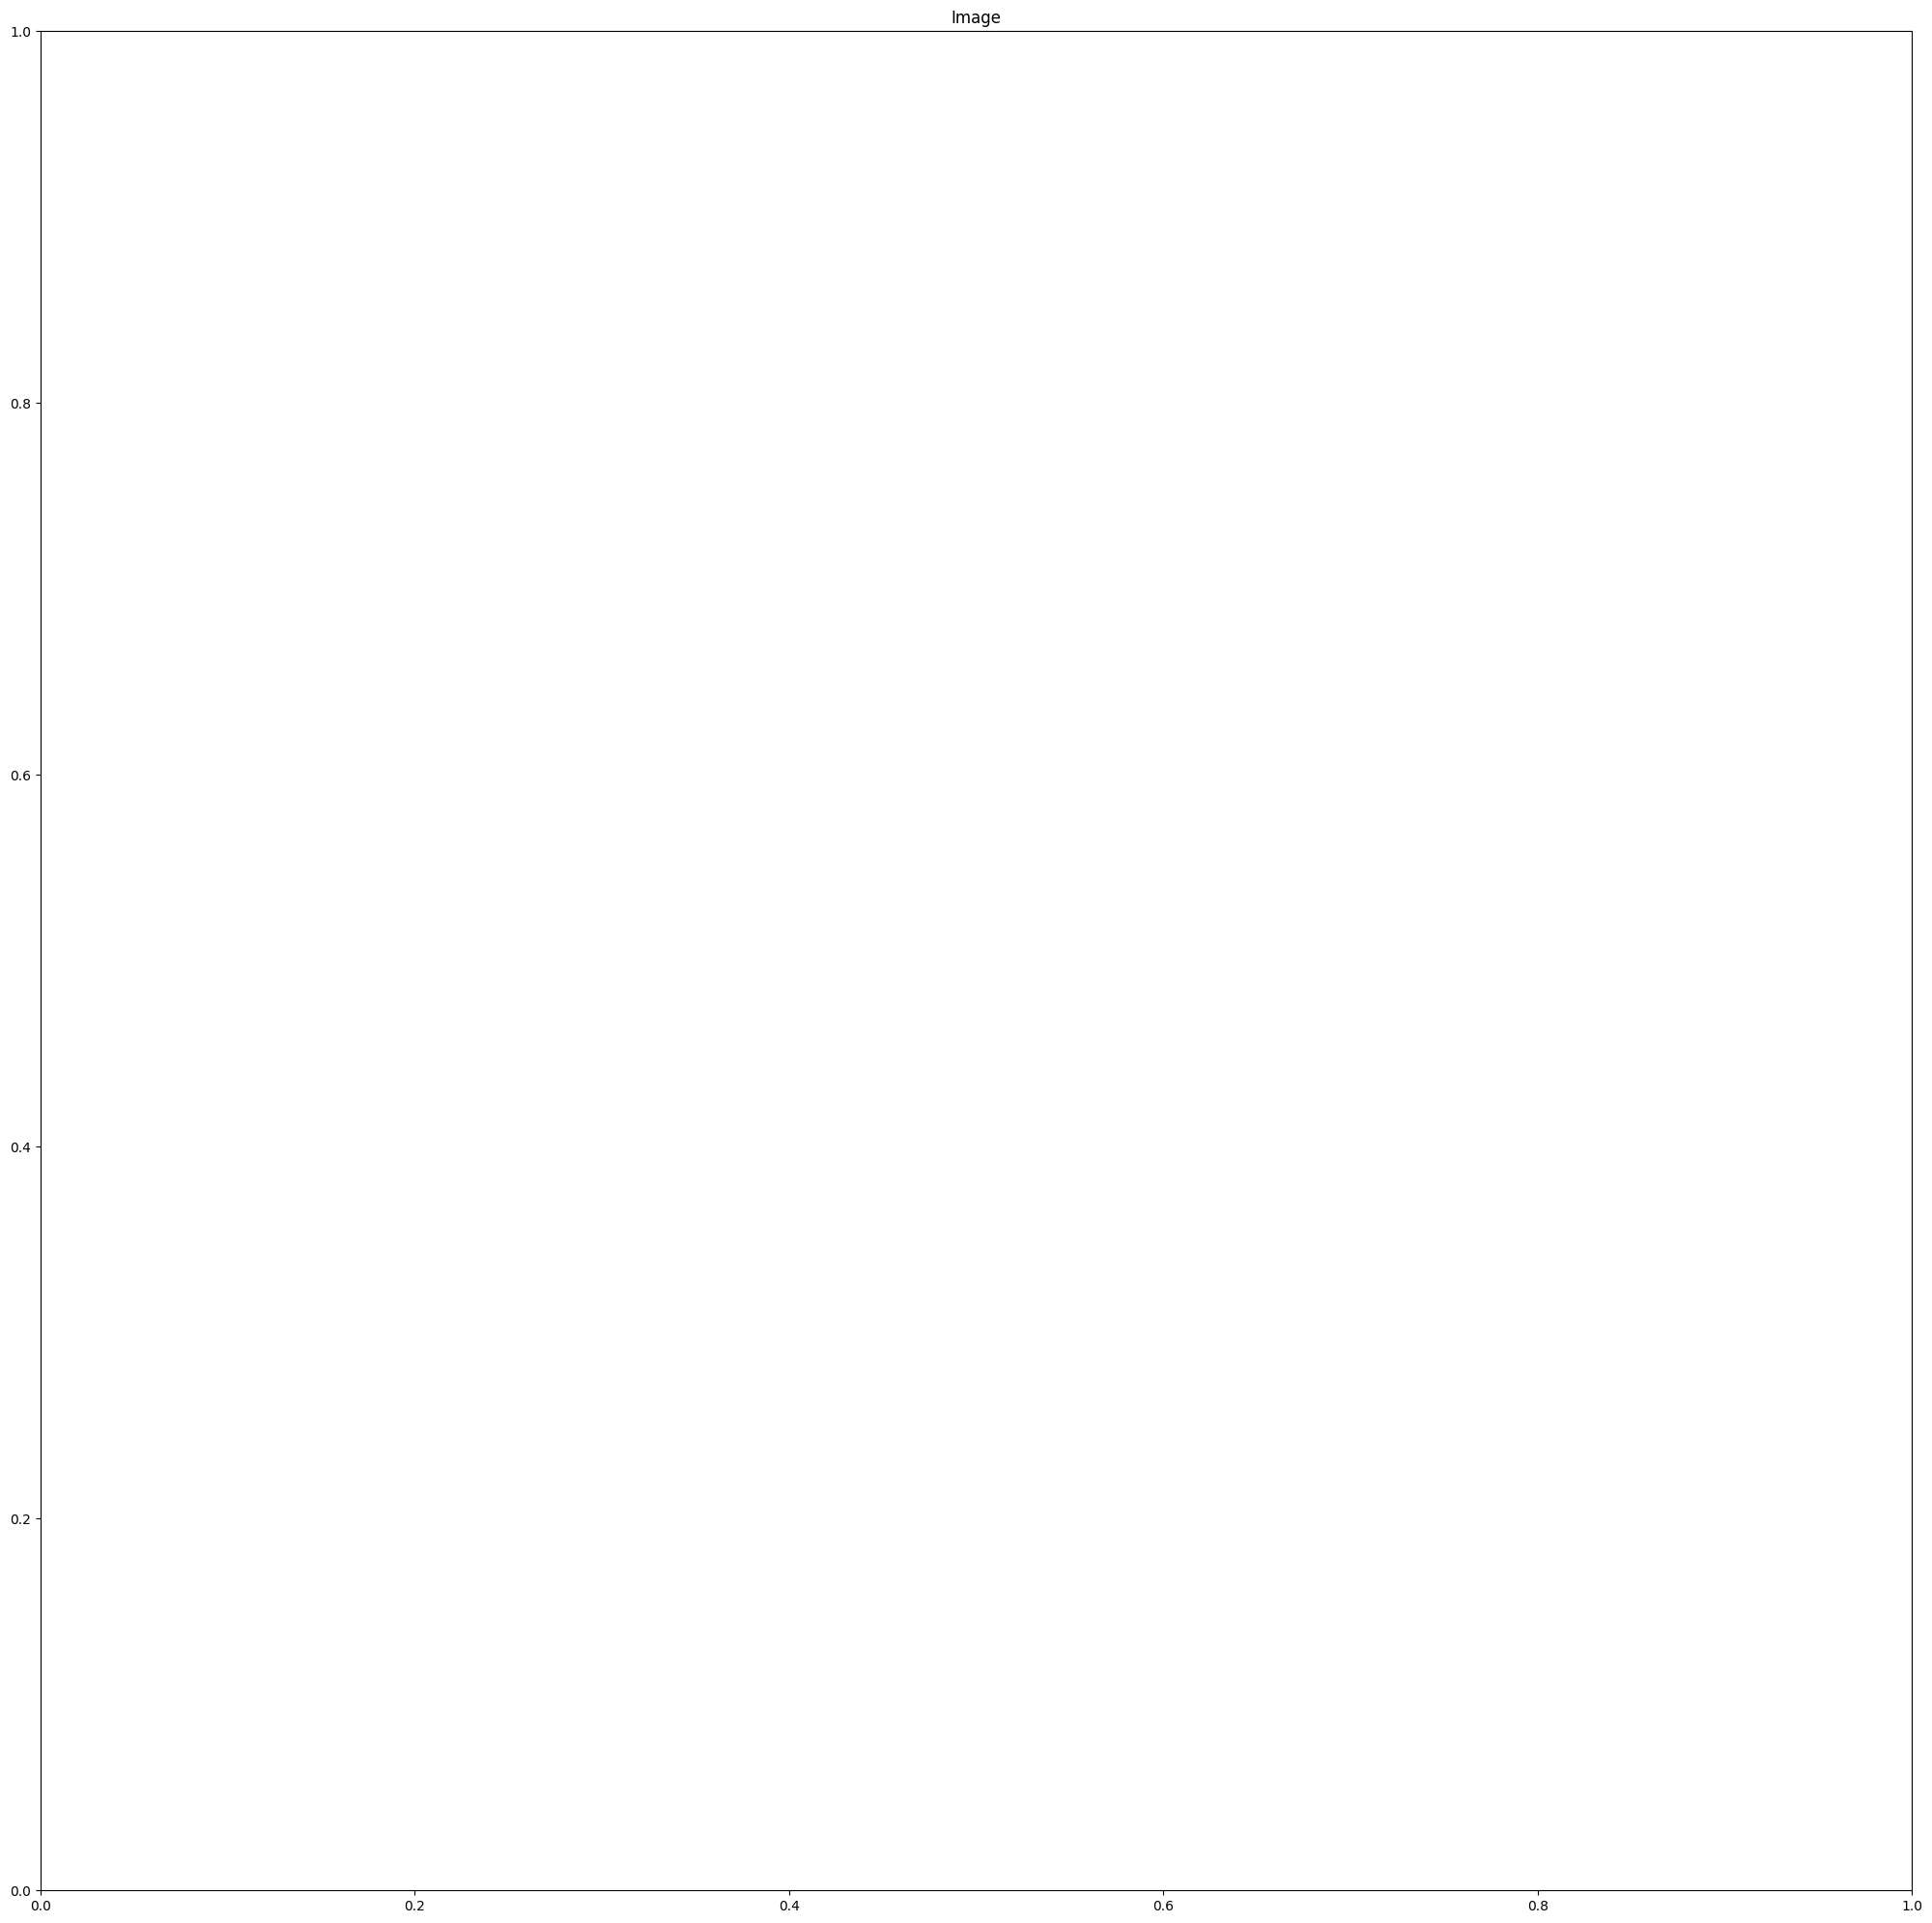

In [18]:
import matplotlib.pyplot as plt
import numpy as np

train_iterator = iter(train_dataset)

num_elements_to_print = 1
for i in range(num_elements_to_print):
    try:
        images, captions = next(train_iterator)
        print("Images:", images)
    
        
        plt.figure(figsize=(25,25))
        #plt.imshow(np.squeeze(images)) 
        plt.title(f"Image")
        plt.show()
        
        #print("Captions:", captions.numpy())
    except StopIteration:
        break


In [16]:
import tensorflow as tf

train_iterator = iter(train_dataset)
print("TI : ", train_iterator)

num_elements_to_print = 5
for _ in range(num_elements_to_print):
    try:
        element = next(train_iterator)
        image_paths, captions = element[0], element[1]

        images_int64 = tf.cast(image_paths, tf.int64)

        print("Image Paths Memories Bring upper : ", images_int64)

    except StopIteration:
        break

valid_iterator = iter(valid_dataset)

for _ in range(num_elements_to_print):
    try:
        element = next(valid_iterator)
        image_paths, captions = element[0], element[1]

        images_int64 = tf.cast(image_paths, tf.int64)

    except StopIteration:
        break



TI :  <tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7f6d8f69dc60>
Image Paths Memories Bring upper :  tf.Tensor(
[[[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  ...

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]


 [[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [2

Converting to Numpy Array

In [17]:
import numpy as np
import sys

train_iterator = iter(train_dataset)

num_elements_to_print = 1

for _ in range(num_elements_to_print):
    try:
        images, captions = next(train_iterator)
        
        np.save('images.npy', images.numpy())
        
    except StopIteration:
        print("Reached end of dataset")
        break


In [28]:
import numpy as np

np.set_printoptions(threshold=np.inf)

loaded_images = np.load('/home/jupyter/tutorials/ai-platform/image_captioning/images.npy')

print("Loaded images shape:", loaded_images)


Loaded images shape: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Defining the Model

In [18]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        with tf.GradientTape() as tape:
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq, training=True
            )

            # 2. Update loss and accuracy
            batch_loss = loss
            batch_acc = acc

        # 3. Get the list of all the trainable weights
        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )

        # 4. Get the gradients
        grads = tape.gradient(loss, train_vars)

        # 5. Update the trainable weights
        self.optimizer.apply_gradients(zip(grads, train_vars))

        # 6. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 7. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    
    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0


        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        with tf.GradientTape() as tape:
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq, training=True
            )

            # 2. Update loss and accuracy
            batch_loss = loss
            batch_acc = acc

        # 6. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 7. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

Training the Model

In [22]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/60
15/15 [==============================] - 33s 1s/step - loss: 6.0242 - acc: 0.0766 - val_loss: 6.0732 - val_acc: 0.0739
Epoch 2/60
15/15 [==============================] - 20s 1s/step - loss: 5.9651 - acc: 0.0828 - val_loss: 5.9829 - val_acc: 0.0814
Epoch 3/60
15/15 [==============================] - 19s 1s/step - loss: 5.8410 - acc: 0.0919 - val_loss: 5.8331 - val_acc: 0.1002
Epoch 4/60
15/15 [==============================] - 20s 1s/step - loss: 5.6641 - acc: 0.1095 - val_loss: 5.6359 - val_acc: 0.1195
Epoch 5/60
15/15 [==============================] - 19s 1s/step - loss: 5.4378 - acc: 0.1355 - val_loss: 5.4138 - val_acc: 0.1531
Epoch 6/60
15/15 [==============================] - 18s 1s/step - loss: 5.2044 - acc: 0.1646 - val_loss: 5.2140 - val_acc: 0.1719
Epoch 7/60
15/15 [==============================] - 19s 1s/step - loss: 4.9842 - acc: 0.1921 - val_loss: 5.0076 - val_acc: 0.1963
Epoch 8/60
15/15 [==============================] - 19s 1s/step - loss: 4.7786 - acc: 0.21

/home/jupyter/tutorials/ai-platform/image_captioning/images/1ba74ecf-cf42-41f2-aa8c-f21f688aca3c_image_5.jpg


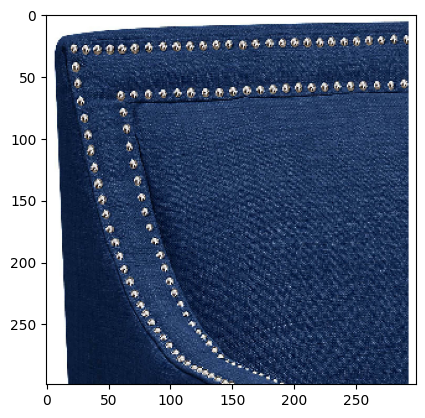

Predicted Caption:  the ellensburg ottoman boasts a refreshing combination of the design with a touch of the touch of the touch of the touch of the soft touch of the soft touch of the soft touch of the soft touch of the soft organic color palette collection adaptable to most 72
/home/jupyter/tutorials/ai-platform/image_captioning/images/2a8d4c56-fa77-4b67-a5a2-87e9a121c19a_image_4.jpg


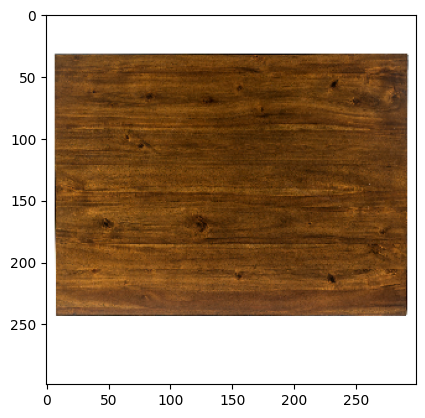

Predicted Caption:  with the linden dresser you can bring stylish accent chair crafted of the a solid pine in a clean lined silhouette mitered front and flared bracket feet for handsome durability and a solid pine planks of the look to create a clean lined and its serpentine look to create
/home/jupyter/tutorials/ai-platform/image_captioning/images/1ae21e59-4ee2-409b-b097-4ef926cd93ee_image_2.jpg


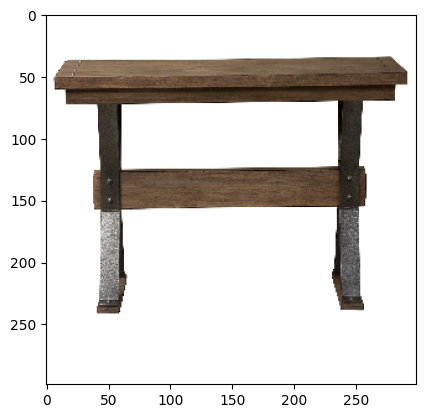

Predicted Caption:  with the linden dresser you can bring home a contemporary feel this set is an ideal living room each piece is comfortable look no further than the table features a worn comfortable for a worn comfortable for a worn comfortable for a worn comfortable look


In [23]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    print(sample_img)
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()